In [1]:
import os
import time
import pickle
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
if os.path.basename(os.getcwd()) != "ML_FILE":
    os.chdir('..')

## 1. Data loading

#### 1.1. Loads accelerations data_set - adds yours data files here to load them

In [3]:
alldfC1 = pd.read_csv('data_sensor/test_ori_V0_3s.csv')
alldfC2 = pd.read_csv('data_sensor/test_ori_V0_3s.csv')

alldfneutral= pd.read_csv('data_sensor/test_neutral.csv')
alldfneutral['Type'] = 'Neutral'

alldfacc = pd.read_csv('data_sensor/test_acc_C2_V0.csv')
alldfacc['Type'] = 'Neutral'
#add yours data files below 


#example: type newdf = pd.read_csv('data_sensor/newdf_data.csv)

This function is to concatenate several dataframe, while keeping consistency of IDs and indexes

In [4]:
def perfect_concat(List_df):
    df = pd.DataFrame()
    def lil_concat(a,b):
        if a.empty:
            return b
        else:
            b['ID'] += a['ID'].max()
            b['index'] += a['index'].max() + 1
            return (pd.concat([a,b], axis = 0, ignore_index=True))
    for i in range(len(List_df)):
        df = lil_concat(df, List_df[i])
    return df

To prepare the dataset, just concat the list of the "littles" datasets

#### 1.2. Get the whole dataset, please modify list data below if you want to add your own data

In [5]:
Ldata = [alldfC1, alldfC2, alldfneutral, alldfacc]
#example : do ListData.append(newdf)

In [6]:
alldf = perfect_concat([alldfC1, alldfC2, alldfneutral, alldfacc])
alldf.shape

(44261, 11)

#### 1.3. Remove the gravity part of the dataset

In [7]:

print(f" Max index : {alldf.index.max()}")
DEG_TO_RAD = np.pi / 180

alldf['X_acc'] = alldf['X_acc'] - 9.81* np.sin(DEG_TO_RAD * alldf['Pitch'])
alldf['Y_acc'] = alldf['Y_acc'] - 9.81 * np.sin(DEG_TO_RAD * alldf['Roll'])*np.cos(DEG_TO_RAD * alldf['Pitch'])
alldf['Z_acc'] = alldf['Z_acc'] - 9.81 * np.cos(DEG_TO_RAD * alldf['Roll'])*np.cos(DEG_TO_RAD * alldf['Pitch'])

all_data = alldf.copy()

 Max index : 44260


#### 1.4. Look on data

Compare number of measures by Type

[Text(0, 0, '10007'),
 Text(0, 0, '11102'),
 Text(0, 0, '10860'),
 Text(0, 0, '12292')]

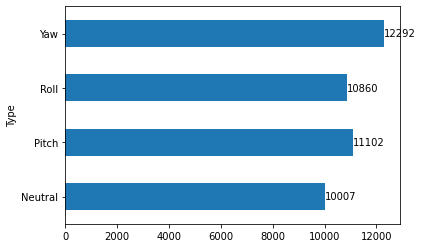

In [8]:
ax = nb_by_type = all_data.groupby('Type').index.nunique().plot.barh()
ax.bar_label(ax.containers[0])

## 2. Tabularize data

#### 2.1. Data creation

we define the number of previous sample considered with length_tab

In [9]:
length_tab = 7
n_id = alldf[alldf['Type'] == 'Roll'].ID.unique().shape[0]

In [10]:
columns = ['ID', 'Type', 'Interval Time', 'Time', 'index']
for i in range(length_tab):
    columns.append(f"X_acc_{i+1}")
    columns.append(f"Y_acc_{i+1}")
    columns.append(f"Z_acc_{i+1}")
    columns.append(f"Roll_{i+1}")
    columns.append(f"Pitch_{i+1}")
    columns.append(f"Yaw_{i+1}")
print(columns)
wide_tab = pd.DataFrame(columns = columns)

lil_tab = alldf.copy()

['ID', 'Type', 'Interval Time', 'Time', 'index', 'X_acc_1', 'Y_acc_1', 'Z_acc_1', 'Roll_1', 'Pitch_1', 'Yaw_1', 'X_acc_2', 'Y_acc_2', 'Z_acc_2', 'Roll_2', 'Pitch_2', 'Yaw_2', 'X_acc_3', 'Y_acc_3', 'Z_acc_3', 'Roll_3', 'Pitch_3', 'Yaw_3', 'X_acc_4', 'Y_acc_4', 'Z_acc_4', 'Roll_4', 'Pitch_4', 'Yaw_4', 'X_acc_5', 'Y_acc_5', 'Z_acc_5', 'Roll_5', 'Pitch_5', 'Yaw_5', 'X_acc_6', 'Y_acc_6', 'Z_acc_6', 'Roll_6', 'Pitch_6', 'Yaw_6', 'X_acc_7', 'Y_acc_7', 'Z_acc_7', 'Roll_7', 'Pitch_7', 'Yaw_7']


#### 2.2. We create the flipper feature : equal to 1 when the ID changes, and zero in the other case
\
"index_start" represent the index for a same ID

In [11]:
lil_tab = lil_tab.sort_values(by = ['ID', 'Time'], ascending = [True, True])
lil_tab['flipper'] = np.where(lil_tab.ID != lil_tab.ID.shift(1), 1, 0)

index_flipper = lil_tab[lil_tab['flipper'] == 1]
index_flipper = index_flipper[['ID', 'index']]
index_flipper.rename({'index' : 'index_start'}, axis = 1, inplace = True)
lil_tab0 = lil_tab.merge(index_flipper, on = 'ID', how = 'left')
lil_tab0['index_start'] = lil_tab0['index'] - lil_tab0['index_start'] #not +1 because I don't want to consider the 
#first value of each sample
lil_tab0['lets_tab'] = np.where((lil_tab0.index_start >= length_tab), 1, 0)

#### 2.3. Let's define the "tabularized" tab

In [12]:
for i in range(length_tab):
    wide_tab[f"X_acc_{i+1}"] = lil_tab["X_acc"].shift(i)
    wide_tab[f"Y_acc_{i+1}"] = lil_tab["Y_acc"].shift(i)
    wide_tab[f"Z_acc_{i+1}"] = lil_tab["Z_acc"].shift(i)
    wide_tab[f"Roll_{i+1}"] = lil_tab["Roll"].shift(i)
    wide_tab[f"Pitch_{i+1}"] = lil_tab["Pitch"].shift(i)
    wide_tab[f"Yaw_{i+1}"] = lil_tab["Yaw"].shift(i)
    
wide_tab["ID"] = lil_tab["ID"]
wide_tab["Type"] = lil_tab["Type"]
wide_tab["Interval Time"] = lil_tab["Interval Time"]
wide_tab["Time"] = lil_tab["Time"]
wide_tab["index"] = lil_tab0["index_start"] - length_tab
wide_tab["lets_tab"] = lil_tab0["lets_tab"]
wide_tab = wide_tab[wide_tab["lets_tab"] == 1]

#### 2.4. wide_tab_diff does only the differenciate non orienation values

In [13]:
wide_tab_diff = wide_tab.copy()

wide_tab_diff['lets_diff'] = np.where(wide_tab_diff.ID != wide_tab_diff.ID.shift(1), 0, 1)
for i in range(length_tab):
    wide_tab_diff[f"X_acc_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'X_acc_{i+1}'], 0)
    wide_tab_diff[f"Y_acc_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Y_acc_{i+1}'], 0)
    wide_tab_diff[f"Z_acc_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Z_acc_{i+1}'], 0)
    wide_tab_diff[f"Roll_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Roll_{i+1}'].diff(), 0)
    wide_tab_diff[f"Pitch_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Pitch_{i+1}'].diff(), 0)
    wide_tab_diff[f"Yaw_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Yaw_{i+1}'].diff(), 0)

    wide_tab_diff.rename({f"Roll_{i+1}" : f"diff_Roll_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff.rename({f"Pitch_{i+1}" : f"diff_Pitch_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff.rename({f"Yaw_{i+1}" : f"diff_Yaw_{i+1}"}, axis = 1, inplace = True)
wide_tab_diff = wide_tab_diff[wide_tab_diff["lets_diff"] == 1]

#### 2.5. The split_train_test function is a special : it does the split on the ID and then consider all samples of the same ID to be in a same train or test group

In [14]:
def get_split_train_test(dff = wide_tab):
    global df
    i = 0 
    while i == 0:
        ## Get a unique list of ID
        aa = wide_tab.copy()
        pd_id = aa.drop_duplicates(subset = 'ID', keep = 'first')
        pd_id = pd_id[['ID', 'Type']]

        ##Create random number between 0 and 1

        pd_id['boogie'] = (np.random.rand(len(pd_id)))
        pd_id['Modeling_Group'] = np.where(pd_id['boogie'] > 0.7, 'Test', 'Train')
        pd_id_pivot = pd_id.pivot_table(index = 'Type', columns = 'Modeling_Group', aggfunc = 'size')
        # pd_id_pivot['Roll']['Test']
        test_values = pd_id_pivot.loc[:]['Test']
        i = test_values[(test_values > (n_id//3)*0.8) & (test_values < (n_id //3) * 1.2)].shape[0] // 3

    pd_id = pd_id.drop(['Type'], axis = 1)
    X_data = pd.merge(dff, pd_id, on = 'ID', how = 'left')
    #print(X_data.head())
    X_train = X_data[X_data['Modeling_Group'] == 'Train']
    y_train = X_train['Type']
    X_train = X_train.drop(['Type','boogie', 'Modeling_Group', 'index', 'Interval Time', 'Time', 'lets_diff'], axis = 1, errors='ignore')

    X_test = X_data[X_data['Modeling_Group'] == 'Test']
    y_test = X_test['Type']
    X_test = X_test.drop(['Type', 'boogie', 'Modeling_Group', 'index', 'Interval Time', 'Time', 'lets_diff'], axis = 1, errors = 'ignore')

    return X_data, X_train, y_train, X_test, y_test



## 3. Model Part

#### 3.1. This function is to quiclkly evaluate the model used

In [15]:
def evaluate_model_tab(alg, X_data, X_train, y_train, X_test, y_test, accuracy_return : bool = False, plot : bool = False, tree = False):
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    X_train = X_train.drop(['ID', 'lets_tab'], axis = 1)
    X_test = X_test.drop(['ID', 'lets_tab'], axis = 1)
    
    clf = alg.fit(X_train, y_train)
    #Predict training set:
    prediction = clf.predict(X_test)
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, prediction)}")
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    y_test_ID['Prediction'] = prediction
    Y_result = y_test_ID.groupby('ID').agg(lambda x: pd.Series.mode(x)[0])
    if plot and tree:
        feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)[:15]
        feat_imp.plot.bar()
        plt.ylabel('Feature Importance Score')
        plt.show()
    score = round(clf.score(X_test, y_test),2)
    print(f"Dumb Accuracy: {score}")
    print(f"Adapted Accuracy: {accuracy_score(Y_result['Type'], Y_result['Prediction']):.2f}")
    if accuracy_return:
        return round(accuracy_score(Y_result['Type'], Y_result['Prediction']),2)
    return clf, score

#### 3.2. An example with  Decision Tree

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

random_state = 99
knn = KNN()
dtc = DecisionTreeClassifier(random_state = 99)
clf = RandomForestClassifier(n_estimators = 1, random_state = 99)

X_data, X_train, y_train, X_test, y_test = get_split_train_test(wide_tab_diff)
rf_tab_micro, score = evaluate_model_tab(dtc, X_data, X_train, y_train, X_test, y_test, accuracy_return=False, plot = False)

Confusion Matrix: 
[[1036   48   62  103]
 [  20 2877   16   32]
 [  76   84 2598   70]
 [ 106   20   28 2740]]
Dumb Accuracy: 0.93
Adapted Accuracy: 0.99


Here, the prediction score is around 90 percent

In [17]:
score

0.93

#### 3.3. uncomment cell below to save in a pickle file

In [18]:
# filename = 'WPC_test_orientation'
# with open(f"classifiers/{filename}.pkl", 'wb') as file:
#       pickle.dump(dtc, file)

## 4. AI part - Ignore if you just want to train on classics ml models

In [20]:
wide_tab_classic = wide_tab_diff.copy()
y_c = wide_tab_classic['Type']
wide_tab_classic = wide_tab_classic.drop(['Type', 'ID', 'Time', 'Interval Time', 'index', 'lets_tab', 'lets_diff'], axis = 1)

AI part, below there is a neural network with one hidden layer of 8 neurons and an output layer of 4 neurons
\
There is a part to uncomment if you want to train the model

In [21]:
import tensorflow as tf
from tensorflow import keras


mapping = {'Roll' : 0, 'Pitch' : 1, 'Yaw' : 2, 'Neutral' : 3}
    
def to_int(l):
    return [mapping[i] for i in l]

#split dataset in features and target variable
X_ai, y_ai = wide_tab_classic.copy(), y_c.copy()
X_ai, y_ai = np.array(X_ai.to_numpy()), np.array(y_ai.to_numpy())
y_ai = np.array(to_int(y_ai))
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_ai_t = scaler.fit_transform(X_ai)
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train_ai ,X_test_ai ,y_train_ai ,y_test_ai =train_test_split(X_ai_t,y_ai,test_size=0.1,random_state=0)
# We'll use Keras to create a Neural network
model = tf.keras.Sequential()
model = tf.keras.Sequential([
    tf.keras.Input(shape=(42,)),
    keras.layers.Dense(8, activation='relu'),
    # keras.layers.Dense(8,activation='relu'),
    keras.layers.Dense(4,activation='sigmoid',
                           )
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
##10 epochs only to avoid losing to much time when running the whole jupyter, 100 in normal time


##UNCOMMENT BELOW IF YOU WANT TO TRAIN THE AI MODEL

#history_1 = model.fit(X_train_ai, y_train_ai, epochs=10, validation_data=(X_test_ai, y_test_ai))

##UNCOMMENT ABOVE IF YOU WANT TO TRAIN THE AI MODEL


# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto'
)

# Exclude the first few epochs so the graph is easier to read
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
SKIP = 10
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Find the weights of the model
weights = model.get_weights()
print(weights)
# Saving the array in a text file
file = open("micropython_codes/ESP32/temporary_models/hyper_param_gyr.txt", "w+")
content = str(weights)
file.write(content)
file.close()
y_pred = model.predict(X_test_ai)
# extract the predicted probabilities
p_pred = model.predict(X_test_ai)
p_pred = p_pred.flatten()

print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predictedch class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)


NameError: name 'history_1' is not defined

### If you want to get the weights to use the micropython models, copy paste them from the hyper_param_gyr.txt file inside of micropython_codes/ESP32/temporary_models and paste them in the MicroPython model